Follow-Along Project: Video: https://www.youtube.com/watch?v=EOzovrGOaJE&t=316s&ab_channel=MattForrest  
original notebook: https://github.com/DahnJ/REM-xarray/blob/master/rem-in-xarray-tutorial.ipynb

Notebook in which I go through a project to have a reference point for aspects of spatial data analysis.

# River Elevation Model Project

**Purpose**: To create a relative elevation map from raster data given by the [US Geologival Survey](https://www.usgs.gov/) for the Mississippi River near Cape Girardeau, MO.

Tools and Resources:
- [USGS 3DEP LidarExplorer](https://apps.nationalmap.gov/lidar-explorer/#/) - "Lidar," short for Light Detection and Ranging, is a remote sensing technology which uses lasers to measure distances, and it can be used to build 3d mapping since it provides highly accurate and detailed info about elevation and topography of the earth's surface. The USGS Lidar Explorer is a platform that allows users to access Lidar data across the US. 
- [BoundingBox](https://boundingbox.klokantech.com/) - Select an area on the map and get precise lat/long bounds in a variety of data formats.
- [OSMnx](https://osmnx.readthedocs.io/en/stable/) - "Python package to easily download, model, analyze, and visualize street networks and other geospatial features from OpenStreetMap."
- [HyRiver](https://docs.hyriver.io/) - "A suite of Python packages that provides a unified API for retrieving geospatial/temporal data from various web services."  
- [Rasterio](https://rasterio.readthedocs.io/en/stable/) - Python library to read and visualize raster data
- [xarray](https://docs.xarray.dev/en/stable/) - Python library for working with multidimensional data
- [rioxarray](https://corteva.github.io/rioxarray/stable/) - rasterio + xarray

In [1]:
import sys
sys.executable

'C:\\Users\\pyrus\\anaconda3\\envs\\gis_elevation\\python.exe'

In [2]:
from pathlib import Path
from IPython.core.display import Video

import numpy as np
import pandas as pd
import geopandas as gpd  # Vector data handling
import osmnx as ox  # Downloading data from OSM-- Open Street Maps

from shapely.geometry import box
from scipy.spatial import cKDTree as KDTree # For Inverse Distance Weight calculation

import xarray as xr    
import xrspatial    # Hillshading
import rioxarray    # Working with geospatial data in xarray

import matplotlib.pyplot as plt
from datashader.transfer_functions import shade, stack

## 1. Sourcing and Loading the Data
From the USGS site, we're sourcing DEM data (Digital Elevation Model). It represents elevation of terrain in a grid, i.e. raster, format, with each cell containing a numerical value for elevation. The selected resolution for the DEM data here is $30m^2$ per cell.  
The sample data for the chosen area comes as a .tif file, which is a standard format for storing raster graphics.




In [3]:
import geojson # functionality for encoding and decoding GeoJSON in python

In [4]:
dem = rioxarray.open_rasterio('USGS_13_n38w090_20230117.tif') # data from 2017-01-17
dem

<xarray.DataArray (band: 1, y: 10812, x: 10812)>
[116899344 values with dtype=float32]
Coordinates:
  * band         (band) int32 1
  * x            (x) float64 -90.0 -90.0 -90.0 -90.0 ... -89.0 -89.0 -89.0 -89.0
  * y            (y) float64 38.0 38.0 38.0 38.0 38.0 ... 37.0 37.0 37.0 37.0
    spatial_ref  int32 0
Attributes:
    AREA_OR_POINT:          Area
    BandDefinitionKeyword:  *
    DataType:               *
    DESCRIPTION:            *
    LAYER_TYPE:             athematic
    RepresentationType:     *
    _FillValue:             -999999.0
    scale_factor:           1.0
    add_offset:             0.0
    long_name:              Layer_1

Clipping the data down--GeoJSON bounding coordinates parameter from BoundingBox.  
Cropping procedure is straight out of the rioxarray [docs](https://corteva.github.io/rioxarray/stable/rioxarray.html#rioxarray-rio-accessors):

In [5]:
# Raw GeoJSON
geom = '''{"type": "Polygon",
                "coordinates":[[
                [-89.5464277378,37.0327029788],
                [-89.222117982,37.0327029788],
                [-89.222117982,37.4366526437],
                [-89.5464277378,37.4366526437],
                [-89.5464277378,37.0327029788]]]}'''

In [6]:
# process to geojson, put in an array for cropping our dem data 
cropping_geometries = [geojson.loads(geom)]
type(cropping_geometries[0])

geojson.geometry.Polygon

Coordinate Reference System (CRS) is a standardized way of representing spatial info. Setting it to the WGS 84 coordinate system ensures the clipping function reads the lat/lon geom data property:

In [7]:
# set up object crop the data with rioxarray clip method
# EPSG:4328 is deprecated, use WSG84
cropped = dem.rio.set_crs('WGS84').rio.clip(geometries=cropping_geometries)
type(cropped)

xarray.core.dataarray.DataArray

In [8]:
# The coarsen xarray function effectively compresses the data, and here we're doing it along two axes.
cropped = cropped.coarsen(x=3, boundary='trim').mean().coarsen(y=3, boundary='trim').mean()

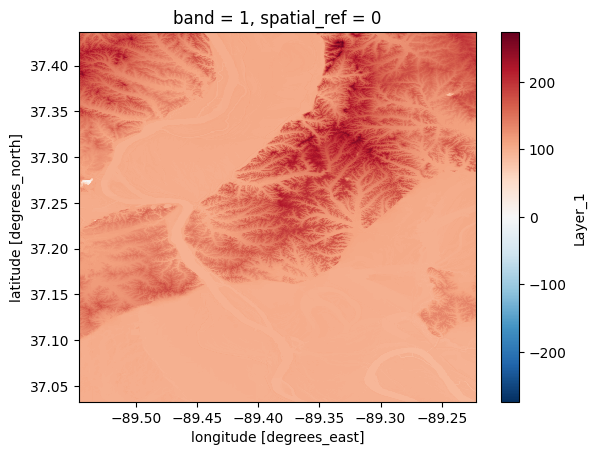

In [9]:
# The squeeze xarray function takes a subset of a dimension, making it easier to plot:
cropped.squeeze().plot.imshow()

We can just kinda make out the river in this plot.

## 2: Fetch the Coordinates of the River

In [10]:
# OSM function use a search term to get GeoDataFrame (GDF) data.
river = ox.geocode_to_gdf('Mississippi River', which_result=1)
# river = river.to_crs(cropped.rio.crs)

CRSError: Invalid projection: epsg:4326: (Internal Proj Error: proj_create: SQLite error on SELECT name, type, coordinate_system_auth_name, coordinate_system_code, datum_auth_name, datum_code, area_of_use_auth_name, area_of_use_code, text_definition, deprecated FROM geodetic_crs WHERE auth_name = ? AND code = ?: no such column: area_of_use_auth_name)

So i'm trying to get some gdf data with osmnx function geocode_to_gdf() with the code:  "ox.geocode_to_gdf('Mississippi River', which_result=1)" It looks like after a pyproj database update that code now results in an error message:

In [12]:
import pyproj
pyproj.datadir.get_data_dir()

'C:\\Users\\pyrus\\anaconda3\\envs\\gis_elevation\\lib\\site-packages\\pyproj\\proj_dir\\share\\proj'

### Left off here. pyproj seems to be pulling from the wrong database. Try a little bit more to fix it, but if you cant get it recrate the env doing conda-forge for everything.
https://github.com/mbforr/youtube-examples/blob/main/relative-elevation-model/rem-in-xarray-tutorial.ipynb
video 12:25. Halkway there. 